In [73]:
import pandas as pd
import pandas_profiling as pp
import matplotlib as plt
import numpy as np
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3)
%matplotlib inline

In [74]:
import datetime

In [75]:
date_parser = lambda ts: datetime.strptime(ts, "%y-%m-%dT%H:%M:%SZ")
df = pd.read_csv('./pricing/aviasales_data_t.csv')
df['requested_at'] = pd.to_datetime(df['requested_at'], format="%y-%m-%dT%H:%M:%SZ", errors="coerce")
df['departure_at'] = pd.to_datetime(df['departure_at'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")
df['expires_at'] = pd.to_datetime(df['expires_at'], format="%Y-%m-%dT%H:%M:%SZ", errors="coerce")
df['price'] = pd.to_numeric(df["price"], errors="coerce")
df = df.dropna()
df

,origin,destination,departure_at,airline,flight_number,price,expires_at,requested_at
0,MOW,LED,2021-03-06 18:45:00,DP,205,3568.0,2021-03-06 13:24:28,2021-03-06 10:28:54
1,MOW,LED,2021-03-07 04:20:00,U6,9631,2438.0,2021-03-07 04:20:00,2021-03-06 10:28:54
2,MOW,LED,2021-03-08 03:45:00,DP,201,2411.0,2021-03-08 03:45:00,2021-03-06 10:28:54
3,MOW,LED,2021-03-09 05:10:00,DP,207,2618.0,2021-03-09 05:10:00,2021-03-06 10:28:54
4,MOW,LED,2021-03-10 04:30:00,DP,209,2468.0,2021-03-09 06:15:06,2021-03-06 10:28:54
...,...,...,...,...,...,...,...,...
334253,SVX,VVO,2021-04-28 07:00:00,U6,274,27524.0,2021-04-27 14:38:28,2021-04-27 06:30:04
334254,SVX,VVO,2021-04-29 10:30:00,S7,5018,29462.0,2021-04-27 18:33:13,2021-04-27 06:30:04
334255,SVX,VVO,2021-04-30 10:30:00,S7,5018,29138.0,2021-04-28 16:12:36,2021-04-27 06:30:04
334256,SVX,YKS,2021-04-28 10:30:00,S7,5018,27406.0,2021-04-28 10:30:00,2021-04-27 06:30:04


In [76]:
# Duplicates? What we consider to be one of them?
# -- Entries with the same 'departure_at', 'expires_at', 'flight_number', 'price' -- Middle priority, easy to fix
df = df.drop_duplicates(subset=['departure_at', 'expires_at', 'airline', 'flight_number', 'price'], keep='first')

departure_at
2021-03-07     8979.000000
2021-03-08     9538.400000
2021-03-09    10269.888889
2021-03-10     9808.571429
2021-03-11     8863.000000
2021-03-12     8717.222222
2021-03-13     9736.142857
2021-03-14     8686.235294
2021-03-15     8823.736842
2021-03-16     8705.409091
2021-03-17     8732.454545
2021-03-18     9997.952381
2021-03-19    14125.782609
2021-03-20    12944.781250
2021-03-21    12908.347826
2021-03-22    11468.771429
2021-03-23     9401.240000
2021-03-24     9507.333333
2021-03-25     9795.750000
2021-03-26    10927.375000
2021-03-27     8567.200000
2021-03-28     8713.547619
2021-03-29     9093.279070
2021-03-30     8514.382979
2021-03-31     8568.507937
2021-04-01     9012.310345
2021-04-02     8714.962963
2021-04-03     8665.548387
2021-04-04     8953.212121
2021-04-05     8367.966667
2021-04-06     8236.238095
2021-04-07     8324.272727
2021-04-08     8840.218750
2021-04-09     8714.277778
2021-04-10     8355.500000
2021-04-11     8365.836735
2021-04-12     

TypeError: 'module' object is not callable

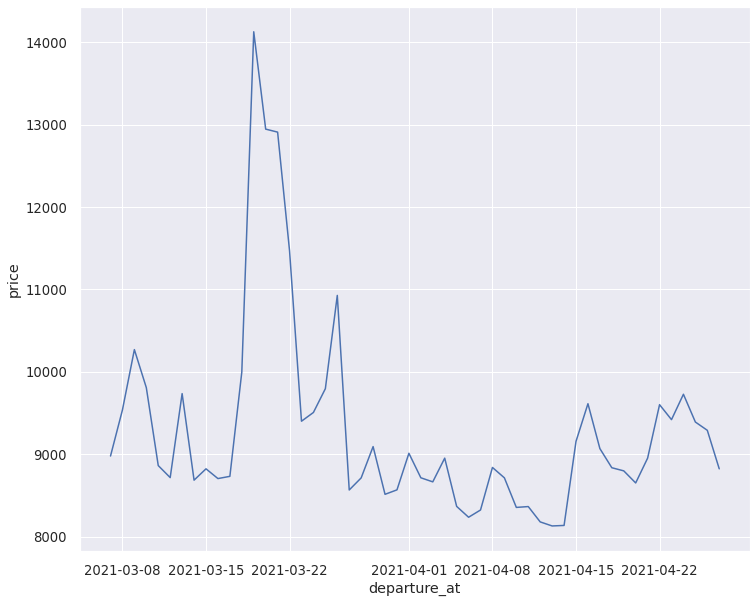

In [77]:
sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize':(12,10)})
#  Avg prices on each day
kzn_soc = df[(df["origin"] == "KZN") & (df["destination"] == "AER") & (df["departure_at"] <= datetime.datetime.now()) & (df["departure_at"] >= "2021-03-07")]
#  2021-03-06 is out

# kzn_soc['day'] = kzn_soc['departure_at'].date
kzn_soc_day = kzn_soc.resample('D', on='departure_at')['price'].mean()
# kzn_soc_day = pd.DataFrame(kzn_soc_day)
# kzn_soc_day['departure_at'] = kzn_soc_day.index
display(kzn_soc_day)
kl = sns.lineplot(data=kzn_soc_day)
kl.set(xlim=(datetime.date(datetime(2021,3,7)), datetime.now()), title="Min prices for KZN-AER in March")

departure_at
0    9115.513761
1    8623.513423
2    8716.839416
3    9363.429825
4    9877.342412
5    9465.760943
6    9208.941368
Name: price, dtype: float64

[Text(0.5, 1.0, 'Average prices for KZN-AER by w-day')]

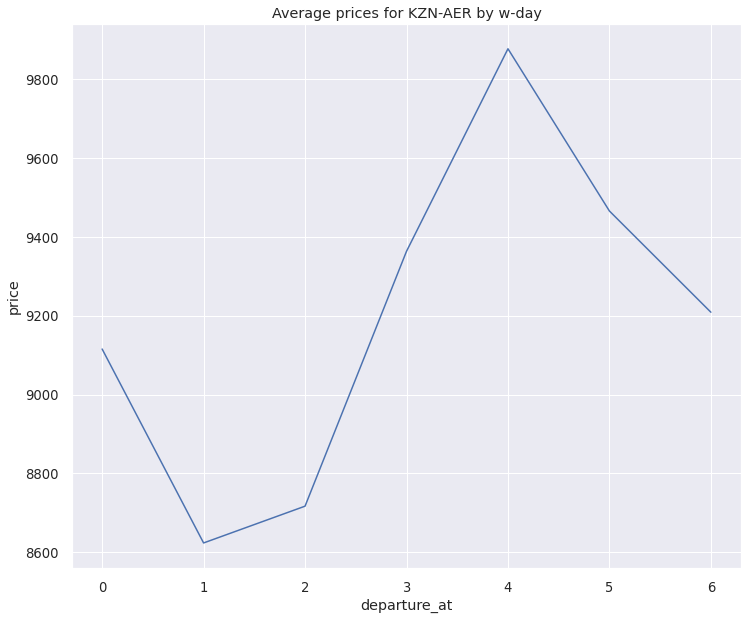

In [78]:
# Avg prices by weekday
kzn_soc_wd = kzn_soc.groupby(kzn_soc['departure_at'].dt.weekday)['price'].mean()
display(kzn_soc_wd)
kwl = sns.lineplot(data=kzn_soc_wd)
kwl.set(title="Average prices for KZN-AER by w-day")

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='price'>)

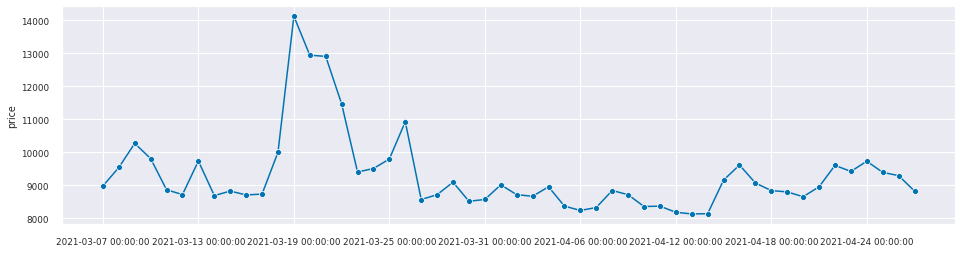

In [79]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import ARIMA, AutoARIMA

sns.set(font_scale=.8)
y = kzn_soc_day
plot_series(y)

39 13


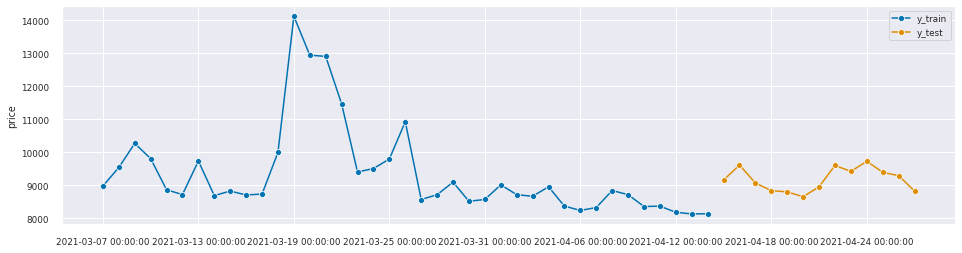

In [80]:
y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

0.11017674846130474

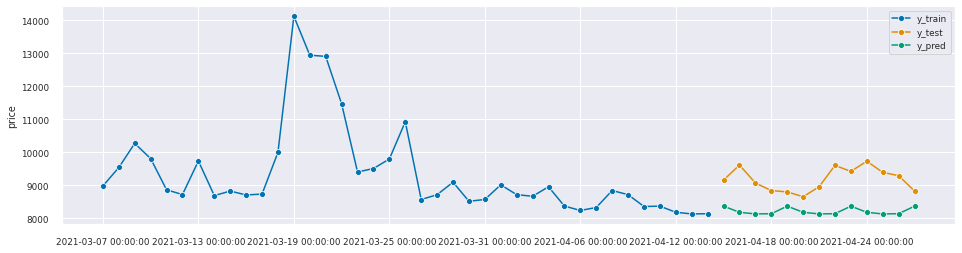

In [81]:
# Naive Forecaster
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last", sp=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

0.12064676757695159

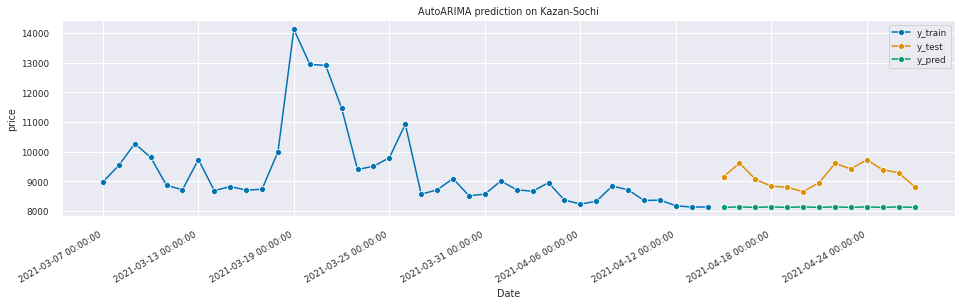

In [82]:
forecaster = AutoARIMA(sp=2) # 2 is best for this case
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.set(title="AutoARIMA prediction on Kazan-Sochi", xlabel="Date")
fig.autofmt_xdate()
smape_loss(y_test, y_pred)

Тренд установился правильно, но присутствует сдвиг вверх

Let's try different destinations, different models, different statistics

По времени до вылета

In [83]:
kzn_soc

,origin,destination,departure_at,airline,flight_number,price,expires_at,requested_at
2187,KZN,AER,2021-03-07 14:00:00,S7,1054,8787.0,2021-03-07 14:00:00,2021-03-06 10:28:54
2188,KZN,AER,2021-03-08 09:25:00,DP,338,10298.0,2021-03-08 09:25:00,2021-03-06 10:28:54
2189,KZN,AER,2021-03-09 18:10:00,N4,137,10201.0,2021-03-08 06:06:18,2021-03-06 10:28:54
2190,KZN,AER,2021-03-10 17:20:00,DP,284,9358.0,2021-03-08 09:24:21,2021-03-06 10:28:54
2191,KZN,AER,2021-03-11 11:45:00,7R,215,8656.0,2021-03-07 10:42:06,2021-03-06 10:28:54
...,...,...,...,...,...,...,...,...
332243,KZN,AER,2021-04-27 08:00:00,DP,338,8685.0,2021-04-27 08:00:00,2021-04-26 00:30:05
332631,KZN,AER,2021-04-26 12:50:00,ZF,345,7911.0,2021-04-26 12:50:00,2021-04-26 06:30:06
332632,KZN,AER,2021-04-27 08:00:00,DP,338,7428.0,2021-04-27 08:00:00,2021-04-26 06:30:06
333015,KZN,AER,2021-04-26 16:45:00,DP,286,10246.0,2021-04-26 16:45:00,2021-04-26 12:30:05


In [84]:
def predict_prices(orgn, dest):
    #  Avg prices on each day, 2021-03-06 is out
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= datetime.datetime.now()) & (df["departure_at"] >= "2021-03-07")]
    # orgn_dest = orgn_dest.dropna()
    orgn_dest_day = orgn_dest.resample('D', on='departure_at')['price'].mean() 
    
    if orgn_dest_day.empty:
        return ("nan", orgn, dest)
    y = orgn_dest_day
    y_train, y_test = temporal_train_test_split(y)
    
    forecaster = AutoARIMA(sp=2, suppress_warnings=True)
    # forecaster = NaiveForecaster(strategy="last")
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return (smape_loss(y_test, y_pred), orgn, dest)

[(0.031601257770391675, 'MOW', 'LED'),
 (0.05739611663087173, 'MOW', 'KZN'),
 (0.07291094129593621, 'MOW', 'CEK'),
 (0.12069427413512591, 'MOW', 'AER'),
 (0.12888764959545138, 'MOW', 'SVX')]

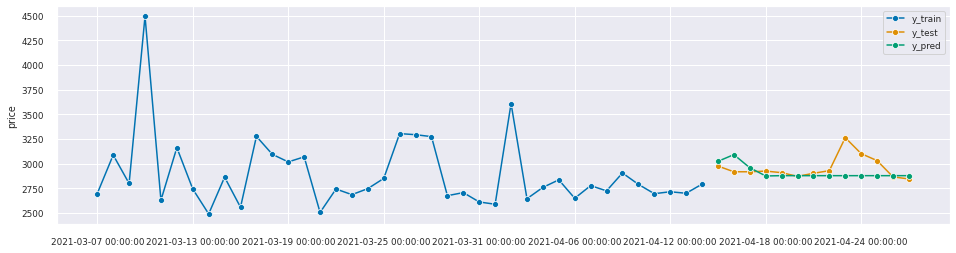

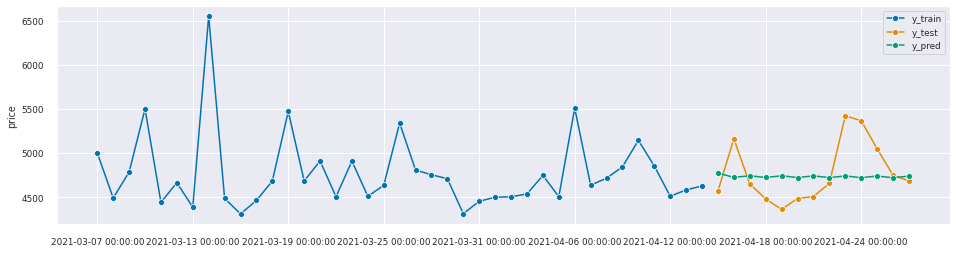

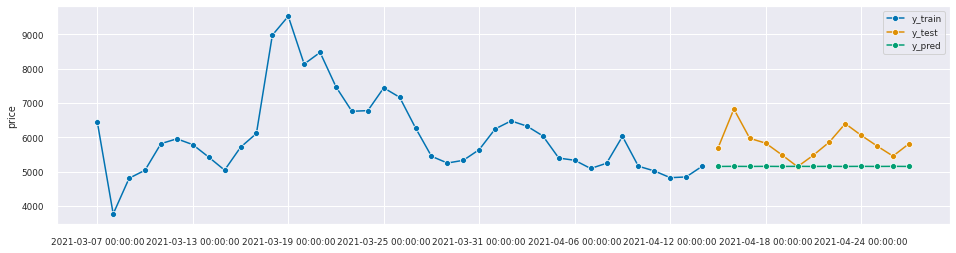

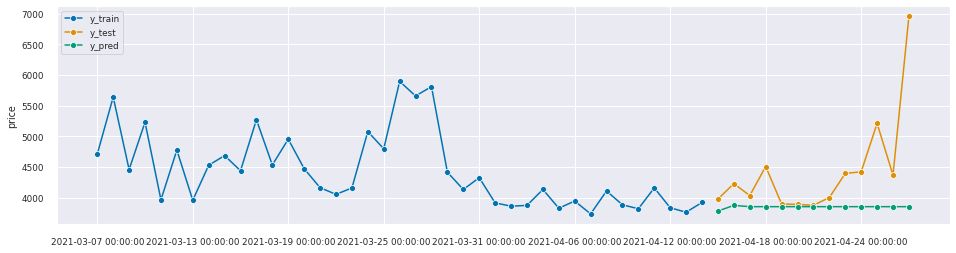

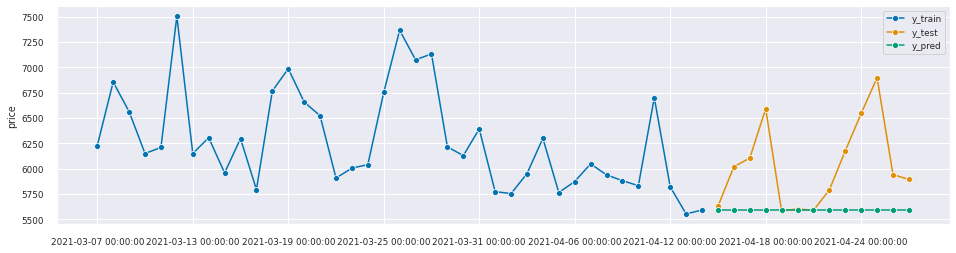

In [85]:
smapes = []
i = "MOW"
#for i in set(df["origin"]):
df_m = df[df["origin"] == "MOW"]
for j in ["LED", "KZN", "AER", "SVX", "CEK"]:
    smapes.append(predict_prices(i, j))
# smapes.append(predict_prices("MOW", "LED"))
clean_smapes = [i for i in smapes if str(i[0]) != "nan"]
clean_smapes.sort()
clean_smapes

Сделать на основе функции выше новую, предсказывающую цены по направлению в зависимости от дней до вылета.

In [86]:
def predict_queried_prices_for(orgn, dest, current_date, flight_date, n_days):
    
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= flight_date) 
                   & (df["requested_at"] >= df["departure_at"] - datetime.timedelta(days=n_days + 1))
                   & (df["requested_at"] <= df["departure_at"] - datetime.timedelta(days=n_days))] 
    # display(orgn_dest)
    
    orgn_dest_day_min = orgn_dest.resample('D', on='requested_at')['price'].min()
  
    orgn_dest_day_min = orgn_dest_day_min.fillna(orgn_dest_day_min.mean())  # not very smart
    
    # display(orgn_dest_day_min)
    
    y = orgn_dest_day_min
    y_train, y_test = temporal_train_test_split(y) # make test smaller?
    
    forecaster = AutoARIMA()
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    # plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
    return round(y_pred[-1])

In [87]:
def predict_queried_prices(orgn, dest, current_date, flight_date):
    days = []
    predictions = []
    delta = flight_date - current_date
    for i in range(delta.days + 1):
        days.append((flight_date - datetime.timedelta(days=i)).strftime("%Y-%m-%d"))
        predictions.append(predict_queried_prices_for(orgn, dest, current_date, flight_date, i))
    return days, predictions

In [88]:
predict_queried_prices("MOW", "KZN", datetime.datetime(2021,4,3), datetime.datetime(2021,4,10))

(['2021-04-10',
  '2021-04-09',
  '2021-04-08',
  '2021-04-07',
  '2021-04-06',
  '2021-04-05',
  '2021-04-04',
  '2021-04-03'],
 [5267, 4565, 4378, 4347, 4297, 4181, 4451, 4483])

In [89]:
# Flight_date has to be before today's
def show_real_prices(orgn, dest, current_date, flight_date, delta_days=7):
    
    orgn_dest = df[(df["origin"] == orgn) & (df["destination"] == dest) & (df["departure_at"] <= flight_date + datetime.timedelta(days=1))
                   & (df["departure_at"] >= flight_date)]
    # display(orgn_dest)
    
    days = []
    prices = []
    for i in range(delta_days + 1):
        orgn_dest_day = orgn_dest[(orgn_dest["requested_at"] >= orgn_dest["departure_at"] - datetime.timedelta(days=i + 1))
                           & (orgn_dest["requested_at"] <= orgn_dest["departure_at"] - datetime.timedelta(days=i))]
        if orgn_dest_day.empty:
            orgn_dest_day = orgn_dest[(orgn_dest["expires_at"] >= orgn_dest["departure_at"] - datetime.timedelta(days=i + 1))
                               & (orgn_dest["expires_at"] <= orgn_dest["departure_at"] - datetime.timedelta(days=i))]
        
        prices.append(round(orgn_dest_day["price"].min()))
        days.append((flight_date - datetime.timedelta(days=i)).strftime("%Y-%m-%d"))
        # display(orgn_dest_day)
    return days, prices

In [90]:
show_real_prices("MOW", "KZN", datetime.datetime(2021,4,3), datetime.datetime(2021,4,10))

(['2021-04-10',
  '2021-04-09',
  '2021-04-08',
  '2021-04-07',
  '2021-04-06',
  '2021-04-05',
  '2021-04-04',
  '2021-04-03'],
 [5698, 4848, 4598, 4848, 4848, 4498, 4498, 4498])

In [91]:
def compare_prediction_results(orgn, dest, current_date, flight_date):
    print("Predictions:", predict_queried_prices(orgn, dest, current_date, flight_date))
    print("Real prices:", show_real_prices("MOW", "KZN", current_date, flight_date))
    # Count metrics

In [92]:
compare_prediction_results("MOW", "KZN", datetime.datetime(2021,4,3), datetime.datetime(2021,4,10))

Predictions: (['2021-04-10', '2021-04-09', '2021-04-08', '2021-04-07', '2021-04-06', '2021-04-05', '2021-04-04', '2021-04-03'], [5267, 4565, 4378, 4347, 4297, 4181, 4451, 4483])
Real prices: (['2021-04-10', '2021-04-09', '2021-04-08', '2021-04-07', '2021-04-06', '2021-04-05', '2021-04-04', '2021-04-03'], [5698, 4848, 4598, 4848, 4848, 4498, 4498, 4498])


In [93]:
import functools
from time import perf_counter

def timer(func):   # memory logs
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = perf_counter()
        value = func(*args, **kwargs)
        tac = perf_counter()
        elapsed_time = tac - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer


In [94]:
from sklearn.metrics import r2_score, mean_squared_log_error, max_error

In [116]:
# Profile prediction func and test prediction quality

def ml_model_test(orgn : str, dest : str,
                  current_date : datetime.datetime, flight_date : datetime.datetime,
                  predictor_f, target_f):
    # predictor_f = timer(predictor_f) # using timer decorator
    print(orgn, dest)
    tic = perf_counter()
    predictions = predictor_f(orgn, dest, current_date, flight_date)
    tac = perf_counter()
    elapsed_time = tac - tic
    
    targets = target_f(orgn, dest, current_date, flight_date)
    print(f"Elapsed time: {elapsed_time:0.4f} seconds")
    print(predictions[1], targets[1])
    
    r2 = r2_score(targets[1], predictions[1])
    msle = mean_squared_log_error(targets[1], predictions[1])
    max_err = max_error(targets[1], predictions[1])
    
    print("R2:", r2)
    print("MSLE:", msle)
    print("Max error:", max_err)
    
    return (str(predictor_f), orgn, dest, elapsed_time, r2, msle, max_err)
    

In [117]:
ml_model_test("MOW", "KZN", datetime.datetime(2021,4,3), datetime.datetime(2021,4,10), predict_queried_prices, show_real_prices)

MOW KZN
Elapsed time: 3.0181 seconds
[5267, 4565, 4378, 4347, 4297, 4181, 4451, 4483] [5698, 4848, 4598, 4848, 4848, 4498, 4498, 4498]
R2: 0.13787635153867484
MSLE: 0.0055133051548212665
Max error: 551


('<function predict_queried_prices at 0x7f1b1d7b7200>',
 'MOW',
 'KZN',
 3.0180627390000154,
 0.13787635153867484,
 0.0055133051548212665,
 551)

In [118]:
import warnings
warnings.filterwarnings('ignore')

In [119]:
str(predict_queried_prices)[1:-2]

'function predict_queried_prices at 0x7f1b1d7b720'

In [123]:
# All routes + all models
i = "MOW"
ml_test_results = []
for i in ['MOW', 'LED']: # NaNs in others , 'KZN', 'CEK', 'SVX', 'AER', 'KRR', 'KGD'
    for j in ['MOW', 'LED', 'KZN', 'CEK', 'SVX', 'AER', 'KRR', 'KGD']: # , 'SGC'
        if i != j:
            ml_test_results.append(ml_model_test(i, j, datetime.datetime(2021,4,20), datetime.datetime(2021,4,27),
                                             predict_queried_prices, show_real_prices))
ml_test_results.append(ml_model_test('MOW', 'SGC', datetime.datetime(2021,4,20), datetime.datetime(2021,4,27),
                                             predict_queried_prices, show_real_prices))            
            
ml_test_df = pd.DataFrame(ml_test_results)
ml_test_df.columns = ['predictor_func', 'origin', 'destination', 'elapsed_time', 'r2_score', 'msle_score', 'max_error']
ml_test_df

MOW LED
Elapsed time: 3.4940 seconds
[3930, 2693, 2636, 2617, 2617, 2682, 2848, 2848] [3221, 2498, 2595, 2531, 2890, 2655, 2890, 3148]
R2: -0.32481120463089264
MSLE: 0.00834292436089073
Max error: 709
MOW KZN
Elapsed time: 5.8300 seconds
[5349, 4556, 4366, 4362, 4293, 4282, 4444, 4483] [4498, 4172, 4248, 4226, 4172, 4172, 4248, 4248]
R2: -11.755989142344855
MSLE: 0.005742554715729202
Max error: 851
MOW CEK
Elapsed time: 2.6931 seconds
[6591, 6150, 6177, 6151, 6388, 6083, 6490, 6212] [5460, 4998, 4998, 5777, 6148, 6148, 5635, 5817]
R2: -2.579604612992147
MSLE: 0.01913142982240603
Max error: 1179
MOW SVX
Elapsed time: 3.5243 seconds
[5714, 4341, 4369, 4291, 4282, 4096, 4280, 4277] [4077, 3658, 3953, 3658, 3658, 3658, 3658, 4058]
R2: -16.707475655374697
MSLE: 0.030455488041556948
Max error: 1637
MOW AER
Elapsed time: 4.1503 seconds
[6365, 5935, 6062, 6005, 5780, 6042, 6221, 6059] [3955, 4123, 5190, 5190, 5586, 5359, 6201, 6163]
R2: -1.293278982074952
MSLE: 0.05252565884005505
Max error: 2

,predictor_func,origin,destination,elapsed_time,r2_score,msle_score,max_error
0,<function predict_queried_prices at 0x7f1b1d7b...,MOW,LED,3.493957,-0.324811,0.008343,709
1,<function predict_queried_prices at 0x7f1b1d7b...,MOW,KZN,5.829971,-11.755989,0.005743,851
2,<function predict_queried_prices at 0x7f1b1d7b...,MOW,CEK,2.693104,-2.579605,0.019131,1179
3,<function predict_queried_prices at 0x7f1b1d7b...,MOW,SVX,3.524259,-16.707476,0.030455,1637
4,<function predict_queried_prices at 0x7f1b1d7b...,MOW,AER,4.150348,-1.293279,0.052526,2410
5,<function predict_queried_prices at 0x7f1b1d7b...,MOW,KRR,4.557123,-7.651814,0.027444,1823
6,<function predict_queried_prices at 0x7f1b1d7b...,MOW,KGD,5.040920,-1.051356,0.024811,1660
7,<function predict_queried_prices at 0x7f1b1d7b...,LED,MOW,6.046364,-4.920356,0.004759,254
8,<function predict_queried_prices at 0x7f1b1d7b...,LED,KZN,4.716381,-19.881633,0.067240,2416
9,<function predict_queried_prices at 0x7f1b1d7b...,LED,CEK,4.061826,-63.608752,0.324351,6476


* Save results
* .py file

Проблемные марштруты Nan: Питер - Сургут, Казань - Челябинск, ...
Проблемные маршруты по качеству предсказаний: Питер - Челябинск (вообще мимо + непонятный выброс на последний день), Питер - Казань (сдвиг), возможно Москва - Екб (сдвиг)